For this exercise, we go to use our best model (ResNet101) and check how are some of the missclasified images.

In [ ]:
# Loading packages
from google.colab import drive
import os
from torchvision import transforms 
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import random
from tqdm.notebook import tqdm
import numpy as np

# Also, as we have a auxiliar python file with function, we go to use it
from cnn_functions import *

In [ ]:
# As our dataset is mounted in Google Drive, we need to get access to it.
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/DeepLearning/dataset/'
classes = os.listdir(data_dir)

Mounted at /content/drive


In [ ]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# Checking the dataset training size
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [ ]:
# Viewing one of images shape
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [ ]:
# Setting seed so that value won't change everytime
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(1)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
# Check the size of each dataset
len(train_ds), len(val_ds),len(test_ds)  

(4590, 270, 540)

In [ ]:
# Define batch size
batch_size = 12
# Define a generator of random values
g_cpu = torch.Generator()
g_cpu.manual_seed(123)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True,generator  = g_cpu)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

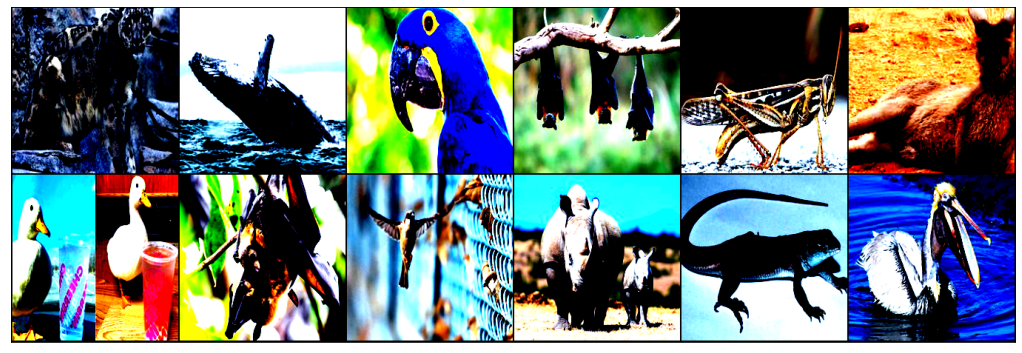

In [ ]:
# We can see some of these images available in one batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=6).permute(1, 2, 0))
    break

In [ ]:
# Now, we go to consider some parameters to start to create our models
input_size = torch.randn(1, 3, 224, 224)
output_size = 90

# Pass our data to GPU
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# **Using ResNet101 with best setting**

In [ ]:
model_resnet101_pt = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model_resnet101_pt.fc = nn.Linear(2048,90)
model_resnet101_pt.eval()
cnn_sdg_lr01_performance = fit_model(model_resnet101_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.281


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.577


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.263


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.144


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.087


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.062


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.044


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.037


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.032


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.024


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.020


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.018


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.016


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.016


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.016


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.014


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.014


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.011


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.014


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.012
Finished Training


In [ ]:
# Use our trained model
trained_model = cnn_sdg_lr01_performance[0]

In [ ]:
# Create a function to identify missclassified cases
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
trained_model.eval()
for data,target in test_loader:
  data , target = data.to(device), target.to(device)
  output = trained_model(data) # shape = torch.Size([batch_size, 10])
  pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
  idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
  if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
    incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
    incorrect_labels.append(target[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
    incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image

# Clean output samples
incorrect_examples_clean = [samples  for samples in incorrect_examples if len(samples) > 0]

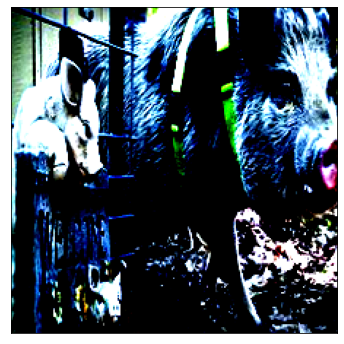

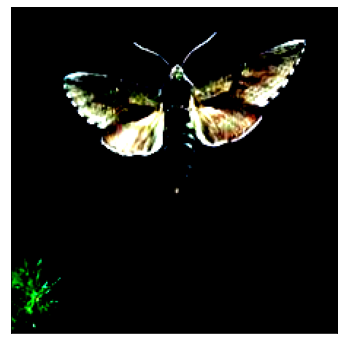

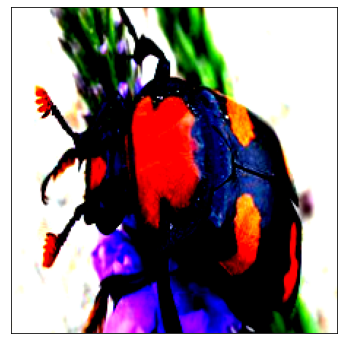

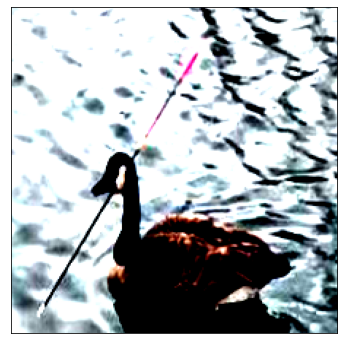

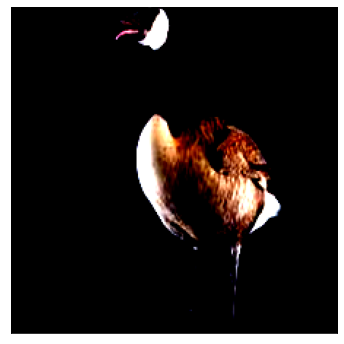

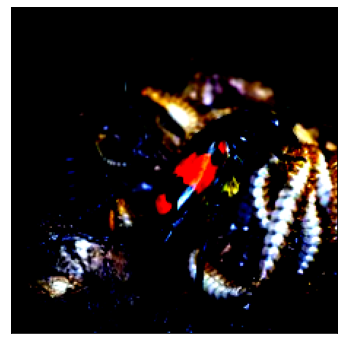

In [ ]:
# Plot some missclassifed images
for images in incorrect_examples_clean[0:6]:
  if len(images) > 0:
    images = torch.from_numpy(images)
    fig, ax = plt.subplots(figsize=(10,6));
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0));
    plt.show();